In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import math
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt
from datasets import load_dataset

g:\UManitoba\DGM\Codes\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z = layers.Dense(latent_dim, name="z")(x)
encoder = keras.Model(encoder_inputs, z, name="encoder")
# encoder.summary()

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=1, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
# decoder.summary()

In [5]:
class AE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            total_loss = reconstruction_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        }
    
    def call(self, inputs):
        z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

In [6]:
ae = AE(encoder, decoder)
ae.load_weights("model/P1T1_AE_mnist.weights.h5")

In [ ]:
num_samples = 10

(x_fashion, _), _ = keras.datasets.fashion_mnist.load_data()

# Convert to (H, W, C) format as the AE expects and normalize the pixel values to [0, 1]
x_fashion = np.expand_dims(x_fashion, -1)
x_fashion = x_fashion.astype("float32") / 255.0

# Randomly select 10 images from the Fashion dataset
indices = np.random.choice(len(x_fashion), num_samples, replace=False)
anomaly_images = x_fashion[indices]

# Use the AE to reconstruct the selected anomaly images
reconstructed = ae.decoder.predict(ae.encoder.predict(anomaly_images))

1/1 [==============================] - 0s 315ms/step


In [ ]:
mse = np.mean((anomaly_images - reconstructed) ** 2, axis=(1,2,3))
print("Reconstruction errors:", mse)

# Output:
# Reconstruction errors: [0.06047587 0.20659783 0.11588331 0.09471458
# 0.07613517 0.11381519 0.152023   0.19535057 0.08753812 0.06928855]

Reconstruction errors: [0.06047587 0.20659783 0.11588331 0.09471458 0.07613517 0.11381519
 0.152023   0.19535057 0.08753812 0.06928855]


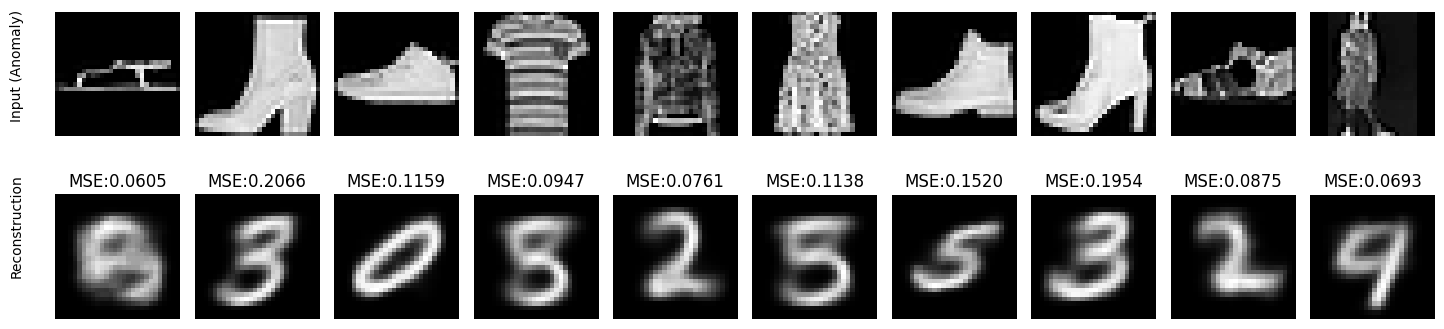

In [31]:
fig, axes = plt.subplots(2, num_samples, figsize=(15, 4))

for i in range(num_samples):
    axes[0, i].imshow(anomaly_images[i], cmap="gray")
    axes[0, i].axis("off")

    axes[1, i].imshow(reconstructed[i], cmap="gray")
    axes[1, i].set_title(f"MSE:{mse[i]:.4f}")
    axes[1, i].axis("off")

fig.text(0.04, 0.75, "Input (Anomaly)", va='center', rotation='vertical')
fig.text(0.04, 0.35, "Reconstruction", va='center', rotation='vertical')

plt.tight_layout(rect=[0.06, 0, 1, 1])
plt.show()